# DeepSphere using SHREC17 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721)
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [4]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from SHREC17.load_shrec import fix_dataset, Shrec17Dataset, Shrec17DatasetCache, Shrec17DatasetTF

## 0.2 Define parameters

In [5]:
Nside = 32
experiment_type = 'CNN' # 'FCN'
ename = '_'+experiment_type
datapath = '../data/shrec17/' # localisation of the .obj files

In [15]:
noise_dataset = True    # use perturbed dataset (Cohen and Esteves do the same)
augmentation = 1        # number of element per file (1 = no augmentation of dataset)
nfeat = 2

## 1 Load dataset

In [7]:
# if datasets are already downloaded but not preprocessed
fix = False
download = False
if fix:
    fix_dataset(datapath+'val_perturbed')
    fix_dataset(datapath+'test_perturbed')

download dataset if True, preprocess data and store it in npy files, and load it in a dataset object

In [ ]:
#train_dataset = Shrec17DatasetCache(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)


Better to keep validation and testing set in RAM, but not always possible

In [8]:
val_dataset = Shrec17DatasetCache(datapath, 'val', perturbed=noise_dataset, download=download, nside=Nside, nfeat=nfeat, augmentation=1, nfile=None)

Try do make a tensorflow dataset object

In [9]:
train_TFDataset = Shrec17DatasetTF(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, nfeat=nfeat, augmentation=augmentation, nfile=None)

In [10]:
#dataset = train_TFDataset.get_tf_dataset(32)

In [11]:
# import time
# import tensorflow as tf

# #dataset = tf_dataset_file(datapath, dataset, file_pattern, 32, Nside, augmentation)
# t_start = time.time()
# data_next = dataset.make_one_shot_iterator().get_next()
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# steps = train_TFDataset.N // 32 + 1
# with tf.Session(config=config) as sess:
#     sess.run(tf.global_variables_initializer())
#     try:
#         for i in range(steps):
#             out = sess.run(data_next)
#     except tf.errors.OutOfRangeError:
#         print("Done") # Never reach this as will iterate on infinite sets
# t_end = time.time()
# print(str(t_end-t_start)+" s")

# # t_start = time.time()
# # data_iter = train_dataset.iter(32)
# # steps = int(train_dataset.N / 32)
# # for i in range(steps):
# #     next(data_iter)
# #     #feed_dict = {self.ph_data: batch_data, self.ph_labels: batch_labels, self.ph_training: True}
# # t_end = time.time()
# # print(str(t_end-t_start)+" s")

## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

In [10]:
nclass = train_TFDataset.nclass
num_elem = train_TFDataset.N
#ids_train = train_dataset.ids
print('number of class:',nclass,'\nnumber of elements:',num_elem)#,'\nfirst id:',ids_train[0])

number of class: 55 
number of elements: 31364


In [13]:
# x_val, labels_val, ids_val = val_dataset.return_data(train=False)

## 2 Classification using DeepSphere

Use of the Dataset object used for other DeepSphere experiments

In [15]:
# #training = LabeledDatasetWithNoise(x_train, labels_train, end_level=sigma_noise)
# #training = LabeledDataset(x_train, labels_train)
# validation = LabeledDataset(x_val, labels_val)

In [11]:
EXP_NAME = 'shrec17_newGraph_best_4K_triplet_{}feat_{}aug_{}sides{}'.format(nfeat, augmentation, Nside, ename)
#EXP_NAME = 'shrec17_Cohen_simple_SGD_max_nsides_300epoch_{}sides{}'.format(Nside, ename)
#EXP_NAME = "shrec17_newGraph_best_4K_7dropout_1aug_32sides_CNN"
#EXP_NAME = 'essai_0loss'

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

Adding a layer in the fully connected can be beneficial

In [12]:
params = hyperparameters.get_params_shrec17_optim(num_elem, EXP_NAME, Nside, nclass, nfeat_in=nfeat, architecture=experiment_type)
params["tf_dataset"] = train_TFDataset.get_tf_dataset(params["batch_size"])
params["std"] = 0.001
params["extra_loss"]=True
model = models.deepsphere(**params)

#sides: [32, 16, 8, 4, 2, 1, 1]
#pixels: [12288, 3072, 768, 192, 48, 12, 12]
#samples per batch: 32
=> #pixels per batch (input): 393,216
=> #pixels for training (input): 19,270,041,600
Learning rate will start at 2.0e-02 and finish at 2.0e-02.
NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 16 / 4 = 49152
    weights: F_0 * F_1 * K_1 = 6 * 16 * 4 = 384
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 3072 * 32 / 4 = 24576
    weights: F_1 * F_2 * K_2 = 16 * 32 * 4 = 2048
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 768 * 64 / 4 = 12288
    weights: F_2 * F_3 * K_3 = 32 * 64 * 4 = 8192
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 192 * 128 / 4 = 6144
    weights: F_3 * F_4 * K_4 = 64 * 128 * 4 = 32768
    biases: F_4 = 128
    batch normalization
  layer 5: cgconv5
   

In [52]:
#EXP_NAME = "shrec17_best_4K_cache_1aug_128sides_CNN"
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

In [ ]:
backup = params.copy()

params, learning_rate = utils.test_learning_rates(params, train_TFDataset.N, 1e-6, 1e-1, num_epochs=20)

shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

model = models.deepsphere(**params)
_, loss_validation, _, _ = model.fit(train_TFDataset, val_dataset, use_tf_dataset=True, cache=True)

params.update(backup)

plt.semilogx(learning_rate, loss_validation, '.-')

NN architecture
  input: M_0 = 196608
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 196608 * 16 / 4 = 786432
    weights: F_0 * F_1 * K_1 = 6 * 16 * 5 = 480
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 49152 * 32 / 4 = 393216
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 12288 * 64 / 4 = 196608
    weights: F_2 * F_3 * K_3 = 32 * 64 * 5 = 10240
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 3072 * 128 / 4 = 98304
    weights: F_3 * F_4 * K_4 = 64 * 128 * 5 = 40960
    biases: F_4 = 128
    batch normalization
  layer 5: cgconv5
    representation: M_4 * F_5 / p_5 = 768 * 256 / 4 = 49152
    weights: F_4 * F_5 * K_5 = 128 * 256 * 5 = 163840
    biases: F_5 = 256
    batch normalization
  Statistical layer: mean
    representation: 1 * 256 = 256
  layer 6: logits

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 0.76 (39 / 5133), f1 (weighted): 0.80, loss: 4.29e+00
  CPU time: 1477s, wall time: 797s, perf_time_load: 1.16s, perf_time: 1.16s
step 980 / 19602 (epoch 1.00 / 20):
  learning_rate = 3.16e-06, training loss = 4.13e+00
  validation accuracy: 3.78 (194 / 5133), f1 (weighted): 2.88, loss: 4.19e+00
  CPU time: 2964s, wall time: 1587s, perf_time_load: 1.13s, perf_time: 1.13s
step 1470 / 19602 (epoch 1.50 / 20):
  learning_rate = 5.62e-06, training loss = 4.08e+00
  validation accuracy: 10.29 (528 / 5133), f1 (weighted): 4.54, loss: 4.00e+00
  CPU time: 4446s, wall time: 2374s, perf_time_load: 1.16s, perf_time: 1.16s
step 1960 / 19602 (epoch 2.00 / 20):
  learning_rate = 9.99e-06, training loss = 3.78e+00
  validation accuracy: 26.57 (1364 / 5133), f1 (weighted): 15.49, loss: 3.70e+00
  CPU time: 5924s, wall time: 3166s, perf_time_load: 1.15s, perf_time: 1.15s
step 2450 / 19602 (epoch 2.50 / 20):
  learning_rate = 1.78e-05, training loss = 3.08e+00
  validation accura

In [ ]:
shutil.rmtree('summaries/lr_finder/', ignore_errors=True)
shutil.rmtree('checkpoints/lr_finder/', ignore_errors=True)

0.9 seems to be a good learning rate for SGD with current parameters

## 2.2 Train Network

In [13]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0
conv1/bias:0
conv2/weights:0
conv2/bias:0
conv3/weights:0
conv3/bias:0
conv4/weights:0
conv4/bias:0
conv5/weights:0
conv5/bias:0
logits/weights:0
the number of parameters in the model is: 189,040


In [14]:
accuracy_validation, loss_validation, loss_training, t_step, t_batch = model.fit(train_TFDataset, val_dataset, use_tf_dataset=True, cache=True)

step 245 / 49006 (epoch 0.25 / 50):
  learning_rate = 2.00e-02, training accuracy = 71.88, training loss = 1.96e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 66.67 (3422 / 5133), f1 (weighted): 62.76, loss: 2.16e+00
  CPU time: 62s, wall time: 34s, perf_time_load: 0.05s, perf_time: 0.00s
step 490 / 49006 (epoch 0.50 / 50):
  learning_rate = 2.00e-02, training accuracy = 75.00, training loss = 1.63e+00
  validation accuracy: 69.69 (3577 / 5133), f1 (weighted): 67.41, loss: 1.91e+00
  CPU time: 121s, wall time: 62s, perf_time_load: 0.05s, perf_time: 0.00s
step 735 / 49006 (epoch 0.75 / 50):
  learning_rate = 2.00e-02, training accuracy = 68.75, training loss = 1.98e+00
  validation accuracy: 71.99 (3695 / 5133), f1 (weighted): 70.52, loss: 1.80e+00
  CPU time: 185s, wall time: 92s, perf_time_load: 0.07s, perf_time: 0.00s
step 980 / 49006 (epoch 1.00 / 50):
  learning_rate = 2.00e-02, training accuracy = 68.75, training loss = 1.72e+00
  validation accuracy: 72.65 (3729 / 5133), f1 (weighted): 70.39, loss: 1.69e+00
  CPU time: 238s, wall time: 118s, perf_time_load: 0.06s, perf_time: 0.00s
step 1225 / 49006 (epoch 1.25 / 

  validation accuracy: 81.84 (4201 / 5133), f1 (weighted): 81.09, loss: 1.05e+00
  CPU time: 1550s, wall time: 790s, perf_time_load: 0.05s, perf_time: 0.00s
step 7840 / 49006 (epoch 8.00 / 50):
  learning_rate = 2.00e-02, training accuracy = 87.50, training loss = 4.66e-01
  validation accuracy: 81.38 (4177 / 5133), f1 (weighted): 80.40, loss: 1.07e+00
  CPU time: 1597s, wall time: 815s, perf_time_load: 0.05s, perf_time: 0.00s
step 8085 / 49006 (epoch 8.25 / 50):
  learning_rate = 2.00e-02, training accuracy = 87.50, training loss = 8.70e-01
  validation accuracy: 82.12 (4215 / 5133), f1 (weighted): 81.43, loss: 1.02e+00
  CPU time: 1644s, wall time: 839s, perf_time_load: 0.05s, perf_time: 0.00s
step 8330 / 49006 (epoch 8.50 / 50):
  learning_rate = 2.00e-02, training accuracy = 78.12, training loss = 8.16e-01
  validation accuracy: 81.18 (4167 / 5133), f1 (weighted): 80.47, loss: 1.05e+00
  CPU time: 1691s, wall time: 863s, perf_time_load: 0.05s, perf_time: 0.00s
step 8575 / 49006 (ep

  validation accuracy: 82.51 (4235 / 5133), f1 (weighted): 82.08, loss: 1.03e+00
  CPU time: 2963s, wall time: 1519s, perf_time_load: 0.05s, perf_time: 0.00s
step 15190 / 49006 (epoch 15.50 / 50):
  learning_rate = 2.00e-02, training accuracy = 100.00, training loss = 1.30e-01
  validation accuracy: 82.49 (4234 / 5133), f1 (weighted): 82.10, loss: 1.02e+00
  CPU time: 3010s, wall time: 1543s, perf_time_load: 0.05s, perf_time: 0.00s
step 15435 / 49006 (epoch 15.75 / 50):
  learning_rate = 2.00e-02, training accuracy = 93.75, training loss = 1.33e-01
  validation accuracy: 82.33 (4226 / 5133), f1 (weighted): 81.89, loss: 1.02e+00
  CPU time: 3058s, wall time: 1568s, perf_time_load: 0.05s, perf_time: 0.00s
step 15680 / 49006 (epoch 16.00 / 50):
  learning_rate = 2.00e-02, training accuracy = 93.75, training loss = 4.55e-01
  validation accuracy: 82.49 (4234 / 5133), f1 (weighted): 81.93, loss: 9.96e-01
  CPU time: 3105s, wall time: 1593s, perf_time_load: 0.05s, perf_time: 0.00s
step 15925

step 22295 / 49006 (epoch 22.75 / 50):
  learning_rate = 2.00e-02, training accuracy = 90.62, training loss = 3.83e-01
  validation accuracy: 82.58 (4239 / 5133), f1 (weighted): 82.10, loss: 1.02e+00
  CPU time: 4384s, wall time: 2261s, perf_time_load: 0.05s, perf_time: 0.00s
step 22540 / 49006 (epoch 23.00 / 50):
  learning_rate = 2.00e-02, training accuracy = 96.88, training loss = 3.65e-01
  validation accuracy: 82.54 (4237 / 5133), f1 (weighted): 82.00, loss: 1.05e+00
  CPU time: 4431s, wall time: 2285s, perf_time_load: 0.05s, perf_time: 0.00s
step 22785 / 49006 (epoch 23.25 / 50):
  learning_rate = 2.00e-02, training accuracy = 96.88, training loss = 1.83e-01
  validation accuracy: 82.58 (4239 / 5133), f1 (weighted): 82.07, loss: 1.05e+00
  CPU time: 4480s, wall time: 2310s, perf_time_load: 0.05s, perf_time: 0.00s
step 23030 / 49006 (epoch 23.50 / 50):
  learning_rate = 2.00e-02, training accuracy = 100.00, training loss = 2.89e-02
  validation accuracy: 82.52 (4236 / 5133), f1 (w

step 29645 / 49006 (epoch 30.25 / 50):
  learning_rate = 2.00e-02, training accuracy = 96.88, training loss = 1.88e-01
  validation accuracy: 82.72 (4246 / 5133), f1 (weighted): 82.55, loss: 1.07e+00
  CPU time: 5801s, wall time: 2990s, perf_time_load: 0.05s, perf_time: 0.00s
step 29890 / 49006 (epoch 30.50 / 50):
  learning_rate = 2.00e-02, training accuracy = 96.88, training loss = 2.13e-01
  validation accuracy: 82.43 (4231 / 5133), f1 (weighted): 82.15, loss: 1.11e+00
  CPU time: 5848s, wall time: 3015s, perf_time_load: 0.05s, perf_time: 0.00s
step 30135 / 49006 (epoch 30.75 / 50):
  learning_rate = 2.00e-02, training accuracy = 100.00, training loss = 8.93e-02
  validation accuracy: 82.76 (4248 / 5133), f1 (weighted): 82.30, loss: 1.10e+00
  CPU time: 5895s, wall time: 3040s, perf_time_load: 0.05s, perf_time: 0.00s
step 30380 / 49006 (epoch 31.00 / 50):
  learning_rate = 2.00e-02, training accuracy = 96.88, training loss = 3.50e-01
  validation accuracy: 82.80 (4250 / 5133), f1 (w

step 36995 / 49006 (epoch 37.75 / 50):
  learning_rate = 2.00e-02, training accuracy = 93.75, training loss = 3.74e-01
  validation accuracy: 82.04 (4211 / 5133), f1 (weighted): 81.49, loss: 1.18e+00
  CPU time: 7218s, wall time: 3725s, perf_time_load: 0.05s, perf_time: 0.00s
step 37240 / 49006 (epoch 38.00 / 50):
  learning_rate = 2.00e-02, training accuracy = 96.88, training loss = 3.07e-01
  validation accuracy: 82.25 (4222 / 5133), f1 (weighted): 81.71, loss: 1.15e+00
  CPU time: 7265s, wall time: 3749s, perf_time_load: 0.05s, perf_time: 0.00s
step 37485 / 49006 (epoch 38.25 / 50):
  learning_rate = 2.00e-02, training accuracy = 100.00, training loss = 1.37e-01
  validation accuracy: 82.78 (4249 / 5133), f1 (weighted): 82.33, loss: 1.11e+00
  CPU time: 7313s, wall time: 3774s, perf_time_load: 0.05s, perf_time: 0.00s
step 37730 / 49006 (epoch 38.50 / 50):
  learning_rate = 2.00e-02, training accuracy = 96.88, training loss = 1.69e-01
  validation accuracy: 82.45 (4232 / 5133), f1 (w

step 44345 / 49006 (epoch 45.24 / 50):
  learning_rate = 2.00e-02, training accuracy = 100.00, training loss = 5.22e-02
  validation accuracy: 82.12 (4215 / 5133), f1 (weighted): 81.75, loss: 1.18e+00
  CPU time: 8663s, wall time: 4477s, perf_time_load: 0.05s, perf_time: 0.00s
step 44590 / 49006 (epoch 45.49 / 50):
  learning_rate = 2.00e-02, training accuracy = 100.00, training loss = 1.75e-01
  validation accuracy: 82.72 (4246 / 5133), f1 (weighted): 82.38, loss: 1.14e+00
  CPU time: 8710s, wall time: 4501s, perf_time_load: 0.05s, perf_time: 0.00s
step 44835 / 49006 (epoch 45.74 / 50):
  learning_rate = 2.00e-02, training accuracy = 96.88, training loss = 2.30e-01
  validation accuracy: 82.23 (4221 / 5133), f1 (weighted): 81.96, loss: 1.18e+00
  CPU time: 8759s, wall time: 4527s, perf_time_load: 0.05s, perf_time: 0.00s
step 45080 / 49006 (epoch 45.99 / 50):
  learning_rate = 2.00e-02, training accuracy = 100.00, training loss = 5.64e-02
  validation accuracy: 82.52 (4236 / 5133), f1 

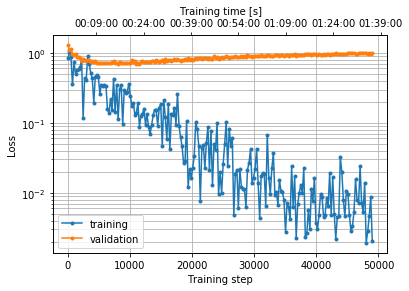

In [37]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

Remarks

In [16]:
model.evaluate(x_train, labels_train)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_nsides_300epoch_reg_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_nsides_300epoch_reg_32sides_CNN/model-294037


('accuracy: 96.53 (30277 / 31364), f1 (weighted): 96.54, loss: 1.16e-01\nCPU time: 275s, wall time: 257s',
 96.53424308123964,
 96.54157073077505,
 0.115866209483545)

In [ ]:
#predictions, loss = model.predict(x_val, labels_val)

In [26]:
# model.evaluate(x_val, labels_val)
model.evaluate(val_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_5K_cache_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_5K_cache_1aug_32sides_CNN/model-49006


('accuracy: 81.86 (4202 / 5133), f1 (weighted): 81.47, loss: 9.74e-01\nCPU time: 12s, wall time: 11s',
 81.86245860120786,
 81.46578216620523,
 0.9739741521947174)

In [27]:
# probabilities = model.probs(x_val, nclass)
probabilities, _ = model.probs(val_dataset, nclass, cache=True)
if augmentation>1:
    probabilities = probabilities.reshape((-1,augmentation,nclass))
    probabilities = probabilities.mean(axis=1)
    #ids_val = ids_val[::repeat]
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_5K_cache_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_5K_cache_1aug_32sides_CNN/model-49006


In [28]:
ids_val = val_dataset.get_ids()

In [ ]:
#predictions = predictions.astype(np.int)

In [32]:
from SHREC17.load_shrec import shrec_output

In [33]:
shrec_output(probabilities, ids_val, datapath, 'results/val_perturbed')

In [34]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_aug/val_perturbed'), exist_ok=True)
for i,_id in enumerate(ids_val):
    idfile = os.path.join(datapath,'results_aug/val_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_val[j]) for j in range(len(ids_val)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

NaN appears if remove i==j case

## test network

In [35]:
test_dataset = Shrec17Dataset(datapath, 'test', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)

10265it [00:20, 493.48it/s]


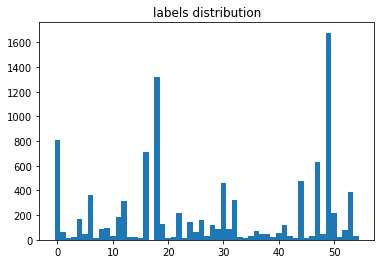

In [36]:
x_test, labels_test, ids_test = test_dataset.return_data(train=False)

In [37]:
model.evaluate(x_test, labels_test)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_5K_cache_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_5K_cache_1aug_32sides_CNN/model-49006


('accuracy: 78.81 (8090 / 10265), f1 (weighted): 78.83, loss: 1.19e+00\nCPU time: 14s, wall time: 13s',
 78.81149537262543,
 78.8281112626363,
 1.1859818069283345)

In [ ]:
#predictions = model.predict(x_test)

In [38]:
probabilities = model.probs(x_test, nclass)
if augmentation>1:
    probabilities = probabilities.reshape((-1,augmentation,nclass))
    probabilities = repeat.mean(axis=1)
#probabilities = np.log(probabilities)
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_5K_cache_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_5K_cache_1aug_32sides_CNN/model-49006


In [ ]:
#predictions = predictions.astype(np.int)

write to file

In [39]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_aug/test_perturbed'), exist_ok=True)
for i, _id in enumerate(ids_test):
    idfile = os.path.join(datapath,'results_aug/test_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_test[j]) for j in range(len(ids_test)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

In [40]:
shrec_output(probabilities, ids_test, datapath, 'results/test_perturbed')

Why not working?

In [62]:
def _print_histogram(nclass, labels_train, labels_min=None):
    if labels_train is None:
        return
    import matplotlib.pyplot as plt
    from collections import Counter
    hist_train=Counter(labels_train)
    if labels_min is not None:
        hist_min = Counter(labels_min)
        hist_temp = hist_train - hist_min
        hist_min = hist_min - hist_train
        hist_train = hist_temp + hist_min
#         for i in range(self.nclass):
#             hist_train.append(np.sum(labels_train == i))
    labels, values = zip(*hist_train.items())
    indexes = np.asarray(labels)
#     miss = set(indexes) - set(labels)
#     if len(miss) is not 0:
#         hist_train.update({elem:0 for elem in miss})
#     labels, values = zip(*hist_train.items())
    width = 1
    plt.bar(labels, values, width)
    plt.title("labels distribution")
    plt.ylim(0,1700)
    #plt.xticks(indexes + width * 0.5, labels)
    plt.show()

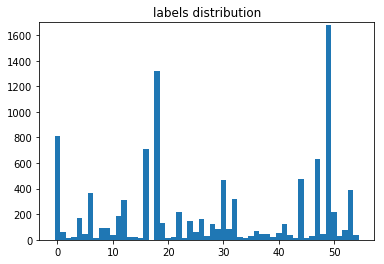

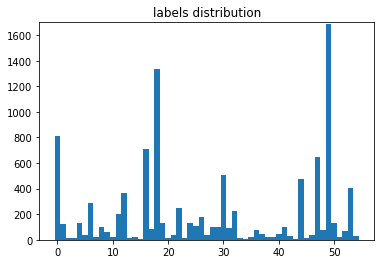

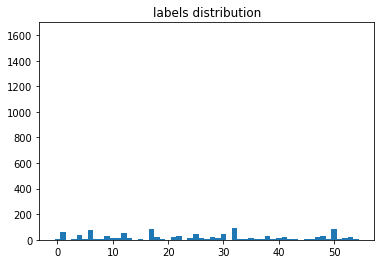

In [63]:
_print_histogram(55, labels_test)
_print_histogram(55, predictions)
_print_histogram(55, labels_test, predictions)

In [43]:
from sklearn.metrics import confusion_matrix

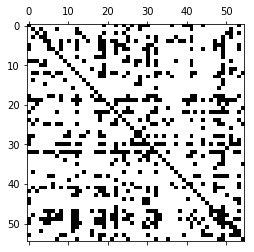

In [44]:
plt.spy(confusion_matrix(labels_test, predictions, range(55)))